# Remote sensing satellite sources

![](https://global-uploads.webflow.com/6198248fab7fc465b00e696a/633da9a8bbfd5981ac8d2dca_632b1dab1dd75cd2c4fb69ad_2020-07-10-remote-monitoring-glossary-fig3.png)

## Spatio Temporal Asset Catalog

https://stacindex.org/

![](https://sa.catapult.org.uk/wp-content/uploads/2023/03/Fig-1.-Visual-overview-of-the-different-parts-of-the-STAC-specification.png)

In [3]:
from pystac_client import Client

In [4]:
import geopandas as gpd
import shapely
import folium

In [5]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [6]:
bbox = (-67.008753, -9.96445, -65.615556, -8.57408)

In [7]:
items = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2019-06-01/2019-06-10"
).get_all_items()

In [8]:
len(items)

26

## stacmap

https://stacmap.readthedocs.io/en/latest/tutorials/quickstart.html

In [12]:
import stacmap

In [13]:
stacmap.explore(
    items, 
    prop="eo:cloud_cover", 
    bbox=bbox
)

## stackstac

https://stackstac.readthedocs.io/en/latest/

In [15]:
import pystac_client

In [16]:
import stackstac

In [17]:
lon, lat = -105.78, 35.79

In [18]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [19]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
).get_all_items()
len(items)



CPU times: user 18.6 ms, sys: 1.39 ms, total: 20 ms
Wall time: 1.1 s


13

In [20]:
%time 
stack = stackstac.stack(items)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [21]:
stack

<xarray.DataArray 'stackstac-23ab0ea7842629ef5331e52987fea285' (time: 13,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(13, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-01T18:04:04 ......
    id                          (time) <U24 'S2B_13SDV_20200401_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y                           (y) float64 4e+06 4e+06 ... 3.89e+06 3.89e+06
    sentinel:sequence           <U1 '0'
    ...                          ...
    instruments                 <U3 'msi'
    eo:cloud_cover              (time) float64 29.24 1.16 27.26 ... 87.33 5.41
    data_coverage               (time) object 33.85 100 33.9 ... 32.84 100 34.29
    updated                     (time) <U24 '2020-09-05T06:23:47.836Z' ... '2...
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [22]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [23]:
monthly

<xarray.DataArray 'stackstac-23ab0ea7842629ef5331e52987fea285' (time: 2,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<stack, shape=(2, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y                           (y) float64 4e+06 4e+06 ... 3.89e+06 3.89e+06
    sentinel:sequence           <U1 '0'
    view:off_nadir              int64 0
    sentinel:grid_square        <U2 'DV'
    ...                          ...
    sentinel:valid_cloud_cover  bool True
    proj:epsg                   int64 32613
    instruments                 <U3 'msi'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32613
  * time                        (time) datetime64[ns] 2020-04-01 2020-05-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [24]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters



In [25]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-23ab0ea7842629ef5331e52987fea285' (time: 2,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(2, 3, 400, 400), dtype=float64, chunksize=(1, 1, 387, 316), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4.275e+05 4.275e+05 ... 4.315e+05
  * y                           (y) float64 3.963e+06 3.963e+06 ... 3.959e+06
    sentinel:sequence           <U1 '0'
    view:off_nadir              int64 0
    sentinel:grid_square        <U2 'DV'
    ...                          ...
    sentinel:valid_cloud_cover  bool True
    proj:epsg                   int64 32613
    instruments                 <U3 'msi'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32613
  * time                        (time) datetime64[ns] 2020-04-01 2020-05-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [26]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()



[#################################       ] | 84% Completed | 114.86 s

/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[########################################] | 100% Completed | 134.47 s


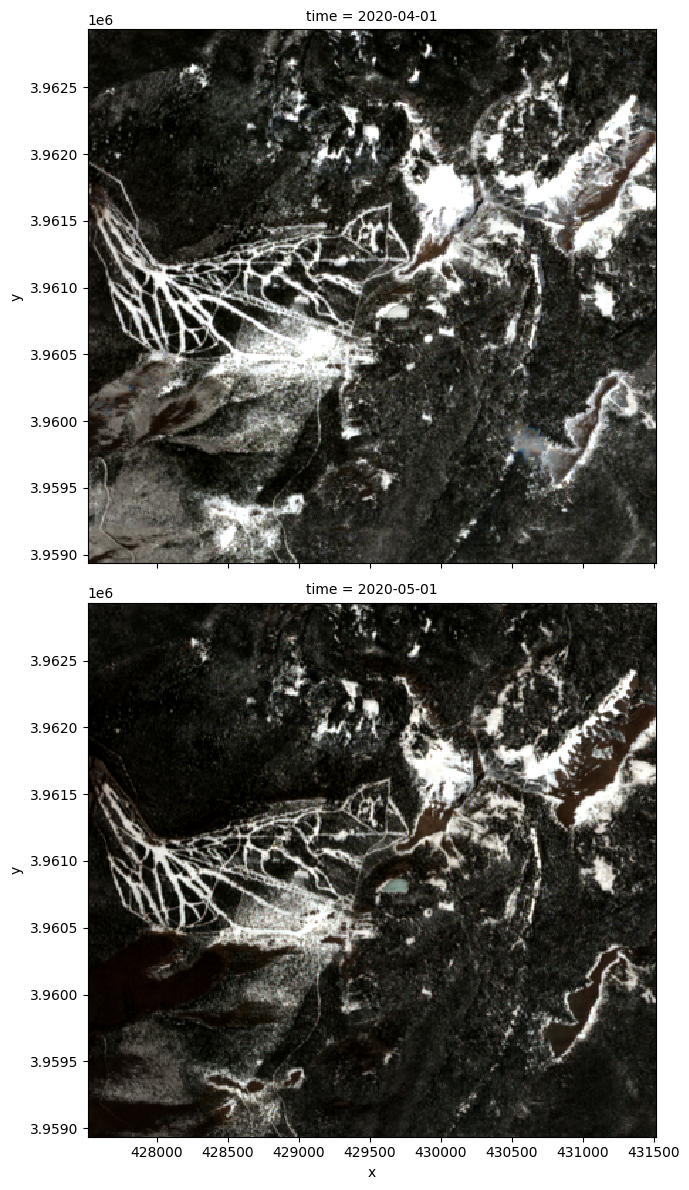

In [27]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);